# PANN Generalization Test: Parametric Scenario Selection

This notebook demonstrates PANN's ability to generalize to unseen loading scenarios. You can configure which scenarios to include in training vs testing.

**Key Question**: Does PANN extrapolate better than baseline when trained on a subset of scenarios?

**Approach**: Train on diverse but limited scenarios, test on completely unseen ones (including sphere).

## Configuration: Select Training and Test Scenarios

Modify these lists to control which scenarios are used for training vs testing.

**Available scenarios**: `uniaxial_x`, `uniaxial_y`, `uniaxial_x_compression`, `uniaxial_y_compression`, `biaxial_2to1`, `equibiaxial`, `equibiaxial_compression`, `phi_45_plane`, `pure_shear`, `radial_45_45`, `simple_shear`, `sphere`

In [1]:
# ============================================================================
# CONFIGURATION: MODIFY THESE TO CHANGE TRAINING/TEST SPLIT
# ============================================================================

# Scenarios to INCLUDE in training (good intermediate set)
training_scenarios = [
    'equibiaxial',
    'pure_shear',
    'radial_45_45',
]

# Scenarios to use for TESTING ONLY (never seen during training)
# These will be used to evaluate generalization capability
test_only_scenarios = [
    'sphere',   
    'equibiaxial_compression',                 # Most important - generic scenario
    'phi_45_plane',
    'uniaxial_x',
    'uniaxial_y',
    'uniaxial_x_compression',
    'uniaxial_y_compression',
    'biaxial_2to1',
    'simple_shear',
]

# Training configuration
RANDOM_STATE = 42
EPOCHS = 100
BATCH_SIZE = 32

print("Training on:", training_scenarios)
print("Testing on:", test_only_scenarios)

Training on: ['equibiaxial', 'pure_shear', 'radial_45_45']
Testing on: ['sphere', 'equibiaxial_compression', 'phi_45_plane', 'uniaxial_x', 'uniaxial_y', 'uniaxial_x_compression', 'uniaxial_y_compression', 'biaxial_2to1', 'simple_shear']


In [2]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from src.data import load_dataset, get_component_names, prepare_data_by_groups
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from src.models.base_model import build_model, train_model, evaluate_model
from src.models.pann_model import build_pann_model, train_pann_model
from src.comparison import (
    compare_predictions,
    compare_residuals,
    compare_metrics,
    generate_comparison_summary,
    plot_error_distribution_comparison
)

plt.rcParams['figure.figsize'] = (12, 4)

/Users/juanaguila/Code/neohookean-ml-pipeline/keras_env/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 1. Load Dataset and Display Scenario Distribution

In [3]:
# Load full dataset
data_path = '/Users/juanaguila/Code/neohookean-data-generator/data/consolidated_all.npz'
data = np.load(data_path)

strains = data['strains']
stresses = data['stresses']
scenario_labels = data['scenario_labels']
case_ids = data['case_ids']

# Convert E_xy to gamma_xy = 2*E_xy
strains_voigt = strains.copy()
# REMOVED: strains_voigt[:, 2] = 2 * strains[:, 2]
# Data generator already provides gamma12 = 2*E12 (Voigt notation)

print(f"Total dataset: {len(strains)} samples")
print(f"\nScenario distribution in full dataset:")
unique_scenarios, counts = np.unique(scenario_labels, return_counts=True)
for scenario, count in zip(unique_scenarios, counts):
    in_train = scenario in training_scenarios
    in_test = scenario in test_only_scenarios
    status = "TRAIN" if in_train else ("TEST" if in_test else "UNUSED")
    print(f"  {scenario:<30} {count:>5} samples  [{status}]")

Total dataset: 15925 samples

Scenario distribution in full dataset:
  biaxial_2to1                     625 samples  [TEST]
  equibiaxial                      625 samples  [TRAIN]
  equibiaxial_compression          625 samples  [TEST]
  phi_45_plane                     625 samples  [TEST]
  pure_shear                       625 samples  [TRAIN]
  radial_45_45                     625 samples  [TRAIN]
  simple_shear                     625 samples  [TEST]
  sphere                          9050 samples  [TEST]
  uniaxial_x                       625 samples  [TEST]
  uniaxial_x_compression           625 samples  [TEST]
  uniaxial_y                       625 samples  [TEST]
  uniaxial_y_compression           625 samples  [TEST]


## 2. Split Dataset by Scenario Configuration

In [4]:
# Validate configuration
all_scenarios = set(unique_scenarios)
train_set = set(training_scenarios)
test_set = set(test_only_scenarios)

# Check for overlap
overlap = train_set & test_set
if overlap:
    raise ValueError(f"Scenarios appear in both training and test: {overlap}")

# Check for invalid scenarios
invalid_train = train_set - all_scenarios
invalid_test = test_set - all_scenarios
if invalid_train:
    raise ValueError(f"Invalid training scenarios: {invalid_train}")
if invalid_test:
    raise ValueError(f"Invalid test scenarios: {invalid_test}")

print("✓ Configuration validated successfully")
print(f"  Training scenarios: {len(training_scenarios)}")
print(f"  Test-only scenarios: {len(test_only_scenarios)}")

✓ Configuration validated successfully
  Training scenarios: 3
  Test-only scenarios: 9


In [5]:
# Create masks for training and test scenarios
train_mask = np.isin(scenario_labels, training_scenarios)
test_unseen_mask = np.isin(scenario_labels, test_only_scenarios)

# Get training data
X_train_scenarios = strains_voigt[train_mask]
y_train_scenarios = stresses[train_mask]
scenarios_train = scenario_labels[train_mask]
case_ids_train = case_ids[train_mask]

# Get test data from unseen scenarios
X_test_unseen = strains_voigt[test_unseen_mask]
y_test_unseen = stresses[test_unseen_mask]
scenarios_test_unseen = scenario_labels[test_unseen_mask]

print(f"\n{'='*70}")
print(f"DATASET SPLIT SUMMARY")
print(f"{'='*70}")
print(f"Training set: {len(X_train_scenarios):>6} samples")
print(f"Test set:     {len(X_test_unseen):>6} samples (unseen scenarios)")
print(f"{'='*70}")

print(f"\nTraining scenario breakdown:")
unique_train, counts_train = np.unique(scenarios_train, return_counts=True)
for scenario, count in zip(unique_train, counts_train):
    print(f"  {scenario:<30} {count:>5} samples")

print(f"\nTest (unseen) scenario breakdown:")
unique_test, counts_test = np.unique(scenarios_test_unseen, return_counts=True)
for scenario, count in zip(unique_test, counts_test):
    print(f"  {scenario:<30} {count:>5} samples")


DATASET SPLIT SUMMARY
Training set:   1875 samples
Test set:      14050 samples (unseen scenarios)

Training scenario breakdown:
  equibiaxial                      625 samples
  pure_shear                       625 samples
  radial_45_45                     625 samples

Test (unseen) scenario breakdown:
  biaxial_2to1                     625 samples
  equibiaxial_compression          625 samples
  phi_45_plane                     625 samples
  simple_shear                     625 samples
  sphere                          9050 samples
  uniaxial_x                       625 samples
  uniaxial_x_compression           625 samples
  uniaxial_y                       625 samples
  uniaxial_y_compression           625 samples


## 3. Further Split Training Data into Train/Val/Test

The training scenarios are split into train/val/test for model training. This creates a "seen" test set.

In [6]:
# Split training scenarios into train/val/test using case-based splitting
# This prevents data leakage by ensuring samples from the same case stay together
data_split = prepare_data_by_groups(
    X_train_scenarios, y_train_scenarios, case_ids_train,
    test_size=0.2, val_size=0.2, random_state=RANDOM_STATE,
    scale=False, split_by='case'
)

# Extract the arrays from the dictionary
X_train = data_split['X_train']
X_val = data_split['X_val']
X_test_seen = data_split['X_test']
y_train = data_split['y_train']
y_val = data_split['y_val']
y_test_seen = data_split['y_test']

print(f"\nFinal split for training:")
print(f"  Train:      {len(X_train):>6} samples")
print(f"  Validation: {len(X_val):>6} samples")
print(f"  Test (seen scenarios):   {len(X_test_seen):>6} samples")
print(f"  Test (unseen scenarios): {len(X_test_unseen):>6} samples")

Splitting by case: 75 unique groups
  Train: 45 groups, 1125 samples
  Val:   15 groups, 375 samples
  Test:  15 groups, 375 samples
  ✓ No group leakage detected

Final split for training:
  Train:        1125 samples
  Validation:    375 samples
  Test (seen scenarios):      375 samples
  Test (unseen scenarios):  14050 samples


## 4. Prepare Data for Both Models

In [7]:
# Scale data for baseline model
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_val_scaled = X_scaler.transform(X_val)
X_test_seen_scaled = X_scaler.transform(X_test_seen)
X_test_unseen_scaled = X_scaler.transform(X_test_unseen)

y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)
y_test_seen_scaled = y_scaler.transform(y_test_seen)
y_test_unseen_scaled = y_scaler.transform(y_test_unseen)

# Package for baseline model (scaled)
data_baseline = {
    'X_train': X_train_scaled,
    'X_val': X_val_scaled,
    'X_test': X_test_seen_scaled,
    'y_train': y_train_scaled,
    'y_val': y_val_scaled,
    'y_test': y_test_seen_scaled,
    'y_test_original': y_test_seen,
    'X_scaler': X_scaler,
    'y_scaler': y_scaler
}

# Package for PANN model (unscaled)
data_pann = {
    'X_train': X_train,
    'X_val': X_val,
    'X_test': X_test_seen,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test_seen,
    'y_test_original': y_test_seen,
    'X_scaler': None,
    'y_scaler': None
}

print("✓ Data prepared for both models")

✓ Data prepared for both models


## 5. Train Baseline Model

In [8]:
print(f"Training Baseline Model on {len(training_scenarios)} scenarios...")
print(f"  Epochs: {EPOCHS}, Batch size: {BATCH_SIZE}")
print()

baseline_model = build_model(input_dim=3, output_dim=3)
baseline_history = train_model(baseline_model, data_baseline, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

baseline_metrics_seen, y_pred_baseline_seen = evaluate_model(baseline_model, data_baseline)
print(f"\nBaseline R² (seen scenarios): {baseline_metrics_seen['r2']:.4f}")
print(f"Baseline params: {baseline_model.count_params():,}")

Training Baseline Model on 3 scenarios...
  Epochs: 100, Batch size: 32

Epoch 1/100


/Users/juanaguila/Code/neohookean-ml-pipeline/keras_env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 1/36 ━━━━━━━━━━━━━━━━━━━━ 33s 945ms/step - loss: 3.7322 - mae: 1.4861

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6435 - mae: 0.9275 - val_loss: 1.2742 - val_mae: 0.8070 - learning_rate: 0.0010


Epoch 2/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9026 - mae: 0.7573

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 0.7861 - mae: 0.6715 - val_loss: 1.1290 - val_mae: 0.7724 - learning_rate: 0.0010


Epoch 3/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9137 - mae: 0.7003

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 0.6517 - mae: 0.5970 - val_loss: 0.9896 - val_mae: 0.7313 - learning_rate: 0.0010


Epoch 4/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4536 - mae: 0.5405

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 0.5020 - mae: 0.5188 - val_loss: 0.8786 - val_mae: 0.7017 - learning_rate: 0.0010


Epoch 5/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3811 - mae: 0.4500

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 0.4434 - mae: 0.4917 - val_loss: 0.7769 - val_mae: 0.6531 - learning_rate: 0.0010


Epoch 6/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4708 - mae: 0.5246

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 0.3925 - mae: 0.4565 - val_loss: 0.6533 - val_mae: 0.6009 - learning_rate: 0.0010


Epoch 7/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3050 - mae: 0.4348

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 0.3574 - mae: 0.4355 - val_loss: 0.5630 - val_mae: 0.5558 - learning_rate: 0.0010


Epoch 8/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5327 - mae: 0.5089

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 0.3350 - mae: 0.4217 - val_loss: 0.4880 - val_mae: 0.5114 - learning_rate: 0.0010


Epoch 9/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2015 - mae: 0.3292

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 0.3111 - mae: 0.3993 - val_loss: 0.3820 - val_mae: 0.4509 - learning_rate: 0.0010


Epoch 10/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2814 - mae: 0.3761

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 0.2958 - mae: 0.3859 - val_loss: 0.2809 - val_mae: 0.3794 - learning_rate: 0.0010


Epoch 11/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1699 - mae: 0.3215

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 0.2880 - mae: 0.3763 - val_loss: 0.2065 - val_mae: 0.3262 - learning_rate: 0.0010


Epoch 12/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1815 - mae: 0.3214

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 0.2702 - mae: 0.3647 - val_loss: 0.1653 - val_mae: 0.2778 - learning_rate: 0.0010


Epoch 13/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2979 - mae: 0.4400

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 0.2397 - mae: 0.3448 - val_loss: 0.1525 - val_mae: 0.2609 - learning_rate: 0.0010


Epoch 14/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2233 - mae: 0.3428

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 0.2566 - mae: 0.3589 - val_loss: 0.1032 - val_mae: 0.2062 - learning_rate: 0.0010


Epoch 15/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2733 - mae: 0.3483

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 0.2321 - mae: 0.3341 - val_loss: 0.0656 - val_mae: 0.1585 - learning_rate: 0.0010


Epoch 16/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3091 - mae: 0.3815

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 0.2463 - mae: 0.3428 - val_loss: 0.0501 - val_mae: 0.1314 - learning_rate: 0.0010


Epoch 17/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1385 - mae: 0.2794

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 0.1835 - mae: 0.3032 - val_loss: 0.0282 - val_mae: 0.1024 - learning_rate: 0.0010


Epoch 18/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1230 - mae: 0.2768

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 0.1929 - mae: 0.3043 - val_loss: 0.0338 - val_mae: 0.1078 - learning_rate: 0.0010


Epoch 19/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1249 - mae: 0.2697

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 0.2080 - mae: 0.3096 - val_loss: 0.0256 - val_mae: 0.0866 - learning_rate: 0.0010


Epoch 20/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2265 - mae: 0.2966

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 0.1889 - mae: 0.2964 - val_loss: 0.0315 - val_mae: 0.0970 - learning_rate: 0.0010


Epoch 21/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1335 - mae: 0.2607

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 0.1913 - mae: 0.3033 - val_loss: 0.0299 - val_mae: 0.0919 - learning_rate: 0.0010


Epoch 22/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1328 - mae: 0.2514

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 0.1611 - mae: 0.2799 - val_loss: 0.0229 - val_mae: 0.0734 - learning_rate: 0.0010


Epoch 23/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1256 - mae: 0.2544

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 0.1724 - mae: 0.2851 - val_loss: 0.0183 - val_mae: 0.0692 - learning_rate: 0.0010


Epoch 24/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1565 - mae: 0.2966

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 0.1624 - mae: 0.2765 - val_loss: 0.0179 - val_mae: 0.0644 - learning_rate: 0.0010


Epoch 25/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1906 - mae: 0.3418

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 0.1699 - mae: 0.2819 - val_loss: 0.0233 - val_mae: 0.0734 - learning_rate: 0.0010


Epoch 26/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0660 - mae: 0.2025

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 0.1693 - mae: 0.2714 - val_loss: 0.0132 - val_mae: 0.0630 - learning_rate: 0.0010


Epoch 27/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1433 - mae: 0.2567

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 0.1784 - mae: 0.2843 - val_loss: 0.0169 - val_mae: 0.0703 - learning_rate: 0.0010


Epoch 28/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1096 - mae: 0.2510

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - loss: 0.1574 - mae: 0.2685 - val_loss: 0.0266 - val_mae: 0.0755 - learning_rate: 0.0010


Epoch 29/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0775 - mae: 0.2004

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 0.1470 - mae: 0.2518 - val_loss: 0.0208 - val_mae: 0.0696 - learning_rate: 0.0010


Epoch 30/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1396 - mae: 0.2888

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 0.1557 - mae: 0.2690 - val_loss: 0.0253 - val_mae: 0.0741 - learning_rate: 0.0010


Epoch 31/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0792 - mae: 0.2162

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 0.1496 - mae: 0.2541 - val_loss: 0.0242 - val_mae: 0.0771 - learning_rate: 0.0010


Epoch 32/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1534 - mae: 0.2482

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 0.1384 - mae: 0.2607 - val_loss: 0.0153 - val_mae: 0.0616 - learning_rate: 0.0010


Epoch 33/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0735 - mae: 0.1864

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 0.1458 - mae: 0.2601 - val_loss: 0.0282 - val_mae: 0.0803 - learning_rate: 0.0010


Epoch 34/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0827 - mae: 0.2241

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 0.1291 - mae: 0.2479 - val_loss: 0.0156 - val_mae: 0.0590 - learning_rate: 0.0010


Epoch 35/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1111 - mae: 0.2267

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 0.1630 - mae: 0.2762 - val_loss: 0.0198 - val_mae: 0.0711 - learning_rate: 0.0010


Epoch 36/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1483 - mae: 0.3146

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 0.1298 - mae: 0.2449 - val_loss: 0.0128 - val_mae: 0.0553 - learning_rate: 0.0010


Epoch 37/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1591 - mae: 0.2562

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 0.1458 - mae: 0.2580 - val_loss: 0.0151 - val_mae: 0.0606 - learning_rate: 0.0010


Epoch 38/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1581 - mae: 0.2491

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - loss: 0.1276 - mae: 0.2479 - val_loss: 0.0153 - val_mae: 0.0662 - learning_rate: 0.0010


Epoch 39/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0606 - mae: 0.1862

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 0.1239 - mae: 0.2366 - val_loss: 0.0151 - val_mae: 0.0625 - learning_rate: 0.0010


Epoch 40/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1997 - mae: 0.2984

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 0.1182 - mae: 0.2399 - val_loss: 0.0085 - val_mae: 0.0563 - learning_rate: 0.0010


Epoch 41/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3135 - mae: 0.4500

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 0.1282 - mae: 0.2526 - val_loss: 0.0282 - val_mae: 0.0874 - learning_rate: 0.0010


Epoch 42/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0884 - mae: 0.2264

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 0.1139 - mae: 0.2315 - val_loss: 0.0176 - val_mae: 0.0714 - learning_rate: 0.0010


Epoch 43/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0808 - mae: 0.2152

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 0.1216 - mae: 0.2434 - val_loss: 0.0082 - val_mae: 0.0500 - learning_rate: 0.0010


Epoch 44/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1397 - mae: 0.2686

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 0.1313 - mae: 0.2532 - val_loss: 0.0092 - val_mae: 0.0598 - learning_rate: 0.0010


Epoch 45/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0630 - mae: 0.1855

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 0.1262 - mae: 0.2396 - val_loss: 0.0146 - val_mae: 0.0649 - learning_rate: 0.0010


Epoch 46/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0942 - mae: 0.2119

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 0.1179 - mae: 0.2350 - val_loss: 0.0078 - val_mae: 0.0573 - learning_rate: 0.0010


Epoch 47/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0576 - mae: 0.1760

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 0.1145 - mae: 0.2313 - val_loss: 0.0072 - val_mae: 0.0466 - learning_rate: 0.0010


Epoch 48/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0702 - mae: 0.2118

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 0.1281 - mae: 0.2496 - val_loss: 0.0060 - val_mae: 0.0541 - learning_rate: 0.0010


Epoch 49/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1183 - mae: 0.2154

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 0.1193 - mae: 0.2429 - val_loss: 0.0070 - val_mae: 0.0509 - learning_rate: 0.0010


Epoch 50/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0654 - mae: 0.1850

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 0.1106 - mae: 0.2339 - val_loss: 0.0064 - val_mae: 0.0523 - learning_rate: 0.0010


Epoch 51/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0943 - mae: 0.2160

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 0.1187 - mae: 0.2370 - val_loss: 0.0062 - val_mae: 0.0513 - learning_rate: 0.0010


Epoch 52/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0736 - mae: 0.1682

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 0.1344 - mae: 0.2536 - val_loss: 0.0077 - val_mae: 0.0520 - learning_rate: 0.0010


Epoch 53/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0919 - mae: 0.2260

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 0.1198 - mae: 0.2439 - val_loss: 0.0061 - val_mae: 0.0498 - learning_rate: 0.0010


Epoch 54/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1467 - mae: 0.2329

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 0.1153 - mae: 0.2383 - val_loss: 0.0064 - val_mae: 0.0527 - learning_rate: 0.0010


Epoch 55/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0798 - mae: 0.2009

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 0.1207 - mae: 0.2397 - val_loss: 0.0060 - val_mae: 0.0572 - learning_rate: 0.0010


Epoch 56/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1122 - mae: 0.2599

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 0.1025 - mae: 0.2243 - val_loss: 0.0048 - val_mae: 0.0448 - learning_rate: 0.0010


Epoch 57/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1277 - mae: 0.2510

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 0.1318 - mae: 0.2533 - val_loss: 0.0151 - val_mae: 0.0699 - learning_rate: 0.0010


Epoch 58/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4090 - mae: 0.4019

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 0.1292 - mae: 0.2496 - val_loss: 0.0055 - val_mae: 0.0535 - learning_rate: 0.0010


Epoch 59/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0573 - mae: 0.1767

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 0.1151 - mae: 0.2357 - val_loss: 0.0069 - val_mae: 0.0539 - learning_rate: 0.0010


Epoch 60/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0727 - mae: 0.2142

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 0.1120 - mae: 0.2423 - val_loss: 0.0051 - val_mae: 0.0479 - learning_rate: 0.0010


Epoch 61/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1775 - mae: 0.2983

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 0.1094 - mae: 0.2363 - val_loss: 0.0092 - val_mae: 0.0609 - learning_rate: 0.0010


Epoch 62/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0649 - mae: 0.1859

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 0.0974 - mae: 0.2190 - val_loss: 0.0054 - val_mae: 0.0529 - learning_rate: 0.0010


Epoch 63/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0610 - mae: 0.1887

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 0.1123 - mae: 0.2339 - val_loss: 0.0063 - val_mae: 0.0532 - learning_rate: 0.0010


Epoch 64/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0480 - mae: 0.1710

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 0.1073 - mae: 0.2290 - val_loss: 0.0049 - val_mae: 0.0462 - learning_rate: 0.0010


Epoch 65/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1237 - mae: 0.2444

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 0.1085 - mae: 0.2378 - val_loss: 0.0049 - val_mae: 0.0497 - learning_rate: 0.0010


Epoch 66/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2228 - mae: 0.3977


Epoch 66: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 0.0957 - mae: 0.2227 - val_loss: 0.0103 - val_mae: 0.0601 - learning_rate: 0.0010


Epoch 67/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0365 - mae: 0.1393

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 0.1066 - mae: 0.2291 - val_loss: 0.0058 - val_mae: 0.0540 - learning_rate: 5.0000e-04


Epoch 68/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2810 - mae: 0.3698

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 0.0912 - mae: 0.2158 - val_loss: 0.0044 - val_mae: 0.0447 - learning_rate: 5.0000e-04


Epoch 69/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0749 - mae: 0.1933

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 0.1059 - mae: 0.2332 - val_loss: 0.0044 - val_mae: 0.0439 - learning_rate: 5.0000e-04


Epoch 70/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0839 - mae: 0.2246

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 0.0982 - mae: 0.2209 - val_loss: 0.0037 - val_mae: 0.0438 - learning_rate: 5.0000e-04


Epoch 71/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0554 - mae: 0.1838

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 0.0945 - mae: 0.2228 - val_loss: 0.0066 - val_mae: 0.0579 - learning_rate: 5.0000e-04


Epoch 72/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0975 - mae: 0.2300

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 0.0999 - mae: 0.2281 - val_loss: 0.0043 - val_mae: 0.0477 - learning_rate: 5.0000e-04


Epoch 73/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0798 - mae: 0.2034

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 0.0987 - mae: 0.2221 - val_loss: 0.0047 - val_mae: 0.0449 - learning_rate: 5.0000e-04


Epoch 74/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0382 - mae: 0.1540

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 0.1042 - mae: 0.2269 - val_loss: 0.0041 - val_mae: 0.0461 - learning_rate: 5.0000e-04


Epoch 75/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0838 - mae: 0.2095

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 0.1084 - mae: 0.2296 - val_loss: 0.0050 - val_mae: 0.0481 - learning_rate: 5.0000e-04


Epoch 76/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0839 - mae: 0.2300

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 0.1046 - mae: 0.2299 - val_loss: 0.0046 - val_mae: 0.0497 - learning_rate: 5.0000e-04


Epoch 77/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2014 - mae: 0.3400

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 0.1038 - mae: 0.2291 - val_loss: 0.0046 - val_mae: 0.0462 - learning_rate: 5.0000e-04


Epoch 78/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0404 - mae: 0.1425

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 0.1159 - mae: 0.2381 - val_loss: 0.0078 - val_mae: 0.0554 - learning_rate: 5.0000e-04


Epoch 79/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0730 - mae: 0.1930

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 0.1041 - mae: 0.2286 - val_loss: 0.0043 - val_mae: 0.0488 - learning_rate: 5.0000e-04


Epoch 80/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3025 - mae: 0.3431


Epoch 80: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 0.1167 - mae: 0.2371 - val_loss: 0.0057 - val_mae: 0.0526 - learning_rate: 5.0000e-04


Epoch 81/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1458 - mae: 0.2635

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 0.1134 - mae: 0.2416 - val_loss: 0.0047 - val_mae: 0.0476 - learning_rate: 2.5000e-04


Epoch 82/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1117 - mae: 0.2440

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 0.0904 - mae: 0.2156 - val_loss: 0.0049 - val_mae: 0.0483 - learning_rate: 2.5000e-04


Epoch 83/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0881 - mae: 0.2219

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 0.1103 - mae: 0.2351 - val_loss: 0.0034 - val_mae: 0.0401 - learning_rate: 2.5000e-04


Epoch 84/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0622 - mae: 0.1818

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 0.1038 - mae: 0.2347 - val_loss: 0.0033 - val_mae: 0.0417 - learning_rate: 2.5000e-04


Epoch 85/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0804 - mae: 0.2158

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 0.0955 - mae: 0.2167 - val_loss: 0.0038 - val_mae: 0.0391 - learning_rate: 2.5000e-04


Epoch 86/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0741 - mae: 0.2104

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 0.1050 - mae: 0.2297 - val_loss: 0.0031 - val_mae: 0.0364 - learning_rate: 2.5000e-04


Epoch 87/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1053 - mae: 0.2171

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 0.1031 - mae: 0.2282 - val_loss: 0.0034 - val_mae: 0.0432 - learning_rate: 2.5000e-04


Epoch 88/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1121 - mae: 0.2798

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 0.1008 - mae: 0.2268 - val_loss: 0.0040 - val_mae: 0.0466 - learning_rate: 2.5000e-04


Epoch 89/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1775 - mae: 0.3378

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 0.1001 - mae: 0.2310 - val_loss: 0.0053 - val_mae: 0.0483 - learning_rate: 2.5000e-04


Epoch 90/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1187 - mae: 0.2136

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 0.0879 - mae: 0.2112 - val_loss: 0.0036 - val_mae: 0.0449 - learning_rate: 2.5000e-04


Epoch 91/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1869 - mae: 0.3557

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 0.1038 - mae: 0.2259 - val_loss: 0.0038 - val_mae: 0.0423 - learning_rate: 2.5000e-04


Epoch 92/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0468 - mae: 0.1732

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 0.1070 - mae: 0.2290 - val_loss: 0.0047 - val_mae: 0.0496 - learning_rate: 2.5000e-04


Epoch 93/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0703 - mae: 0.2016

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 0.0936 - mae: 0.2140 - val_loss: 0.0054 - val_mae: 0.0533 - learning_rate: 2.5000e-04


Epoch 94/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1039 - mae: 0.2562

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 0.0990 - mae: 0.2259 - val_loss: 0.0044 - val_mae: 0.0490 - learning_rate: 2.5000e-04


Epoch 95/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0441 - mae: 0.1713

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 0.0950 - mae: 0.2220 - val_loss: 0.0037 - val_mae: 0.0426 - learning_rate: 2.5000e-04


Epoch 96/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1031 - mae: 0.2452


Epoch 96: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 0.0960 - mae: 0.2190 - val_loss: 0.0075 - val_mae: 0.0525 - learning_rate: 2.5000e-04


Epoch 97/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0732 - mae: 0.2071

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 0.1114 - mae: 0.2385 - val_loss: 0.0055 - val_mae: 0.0485 - learning_rate: 1.2500e-04


Epoch 98/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0911 - mae: 0.1877

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 0.0998 - mae: 0.2286 - val_loss: 0.0044 - val_mae: 0.0468 - learning_rate: 1.2500e-04


Epoch 99/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2514 - mae: 0.3703

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 0.1047 - mae: 0.2309 - val_loss: 0.0040 - val_mae: 0.0462 - learning_rate: 1.2500e-04


Epoch 100/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0707 - mae: 0.2129

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - loss: 0.1127 - mae: 0.2403 - val_loss: 0.0037 - val_mae: 0.0435 - learning_rate: 1.2500e-04


Restoring model weights from the end of the best epoch: 86.



Baseline R² (seen scenarios): 0.9981
Baseline params: 11,843


## 6. Train PANN Model

In [9]:
print(f"Training PANN Model on {len(training_scenarios)} scenarios...")
print(f"  Epochs: {EPOCHS}, Batch size: {BATCH_SIZE}")
print()

pann_model = build_pann_model(n=128, layer_num=2, learning_rate=0.001)
pann_history = train_pann_model(pann_model, data_pann, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

pann_metrics_seen, y_pred_pann_seen = evaluate_model(pann_model, data_pann)
print(f"\nPANN R² (seen scenarios): {pann_metrics_seen['r2']:.4f}")
print(f"PANN params: {pann_model.count_params():,}")

Training PANN Model on 3 scenarios...
  Epochs: 100, Batch size: 32



Epoch 1/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - loss: 109764042752.0000 - mae: 174263.2969

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 136110317568.0000 - mae: 213950.1719 - val_loss: 235116904448.0000 - val_mae: 321769.3750 - learning_rate: 0.0010


Epoch 2/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 119761330176.0000 - mae: 193838.0469

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 136046206976.0000 - mae: 213902.9688 - val_loss: 234897260544.0000 - val_mae: 321622.2500 - learning_rate: 0.0010


Epoch 3/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 131531300864.0000 - mae: 216167.9062

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 135822983168.0000 - mae: 213738.6562 - val_loss: 234282532864.0000 - val_mae: 321208.6250 - learning_rate: 0.0010


Epoch 4/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 172322963456.0000 - mae: 235691.6250

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 135314481152.0000 - mae: 213352.4688 - val_loss: 233030828032.0000 - val_mae: 320361.9375 - learning_rate: 0.0010


Epoch 5/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 116195041280.0000 - mae: 198083.8750

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 134391349248.0000 - mae: 212656.8281 - val_loss: 230958284800.0000 - val_mae: 318951.5312 - learning_rate: 0.0010


Epoch 6/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 135435558912.0000 - mae: 199164.2500

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 132941209600.0000 - mae: 211563.4219 - val_loss: 227889201152.0000 - val_mae: 316847.6250 - learning_rate: 0.0010


Epoch 7/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 177682022400.0000 - mae: 223306.4688

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 130851430400.0000 - mae: 209964.6719 - val_loss: 223717736448.0000 - val_mae: 313962.9375 - learning_rate: 0.0010


Epoch 8/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 149745631232.0000 - mae: 240780.2188

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 128012558336.0000 - mae: 207760.7188 - val_loss: 218107658240.0000 - val_mae: 310039.8438 - learning_rate: 0.0010


Epoch 9/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 92874145792.0000 - mae: 183574.0781

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 124365209600.0000 - mae: 204892.8125 - val_loss: 211162382336.0000 - val_mae: 305110.1875 - learning_rate: 0.0010


Epoch 10/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 86417489920.0000 - mae: 175489.4062

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 119881719808.0000 - mae: 201293.3438 - val_loss: 202521640960.0000 - val_mae: 298860.0000 - learning_rate: 0.0010


Epoch 11/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 71521443840.0000 - mae: 168075.5000

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 114484772864.0000 - mae: 196776.6406 - val_loss: 192252428288.0000 - val_mae: 291251.7188 - learning_rate: 0.0010


Epoch 12/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 107994726400.0000 - mae: 189728.5469

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 108084314112.0000 - mae: 191337.7969 - val_loss: 180283621376.0000 - val_mae: 282115.4688 - learning_rate: 0.0010


Epoch 13/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 156096839680.0000 - mae: 219708.5938

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 100852113408.0000 - mae: 184911.2656 - val_loss: 166936313856.0000 - val_mae: 271550.2500 - learning_rate: 0.0010


Epoch 14/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 39854886912.0000 - mae: 105208.9844

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 92591554560.0000 - mae: 177450.9531 - val_loss: 152067702784.0000 - val_mae: 259249.6562 - learning_rate: 0.0010


Epoch 15/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 102615654400.0000 - mae: 206563.2188

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 84009517056.0000 - mae: 169037.8594 - val_loss: 136162942976.0000 - val_mae: 245378.3281 - learning_rate: 0.0010


Epoch 16/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 67261112320.0000 - mae: 153661.2344

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 74846904320.0000 - mae: 159743.2656 - val_loss: 120635138048.0000 - val_mae: 230989.9062 - learning_rate: 0.0010


Epoch 17/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 53079371776.0000 - mae: 121324.2500

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 65389146112.0000 - mae: 149564.7188 - val_loss: 104243888128.0000 - val_mae: 214698.4531 - learning_rate: 0.0010


Epoch 18/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 56541364224.0000 - mae: 144894.6094

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 55800586240.0000 - mae: 138336.8438 - val_loss: 87534215168.0000 - val_mae: 196602.9219 - learning_rate: 0.0010


Epoch 19/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 50002796544.0000 - mae: 100340.3516

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 46472876032.0000 - mae: 126183.8203 - val_loss: 71878926336.0000 - val_mae: 177887.2500 - learning_rate: 0.0010


Epoch 20/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 41995059200.0000 - mae: 121520.1562

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 37753917440.0000 - mae: 113980.3281 - val_loss: 57594560512.0000 - val_mae: 158736.2188 - learning_rate: 0.0010


Epoch 21/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 48037011456.0000 - mae: 125006.0547

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 29830283264.0000 - mae: 101101.9219 - val_loss: 44963831808.0000 - val_mae: 139447.7188 - learning_rate: 0.0010


Epoch 22/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25848205312.0000 - mae: 93960.2734

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 23051988992.0000 - mae: 88597.2422 - val_loss: 34297128960.0000 - val_mae: 120556.4297 - learning_rate: 0.0010


Epoch 23/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 40820277248.0000 - mae: 109631.1562

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 17357391872.0000 - mae: 76360.5156 - val_loss: 25640153088.0000 - val_mae: 102742.8047 - learning_rate: 0.0010


Epoch 24/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14097199104.0000 - mae: 63832.3945

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12761904128.0000 - mae: 64955.1992 - val_loss: 18809171968.0000 - val_mae: 86902.9062 - learning_rate: 0.0010


Epoch 25/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5147669504.0000 - mae: 45668.3242

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9241392128.0000 - mae: 54810.3516 - val_loss: 13721375744.0000 - val_mae: 73436.7578 - learning_rate: 0.0010


Epoch 26/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6527512576.0000 - mae: 46849.3984

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 6714447872.0000 - mae: 46434.4258 - val_loss: 10413015040.0000 - val_mae: 63817.1523 - learning_rate: 0.0010


Epoch 27/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4330697728.0000 - mae: 43538.7656

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 5010817536.0000 - mae: 39838.1602 - val_loss: 8045324288.0000 - val_mae: 56002.0781 - learning_rate: 0.0010


Epoch 28/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6180164096.0000 - mae: 46170.5898

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 3826913024.0000 - mae: 34713.6836 - val_loss: 6545136640.0000 - val_mae: 50171.0625 - learning_rate: 0.0010


Epoch 29/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5071477760.0000 - mae: 39627.0156

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 3080784384.0000 - mae: 30730.3262 - val_loss: 5498996224.0000 - val_mae: 45258.6680 - learning_rate: 0.0010


Epoch 30/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2124590336.0000 - mae: 30878.3438

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 2568343296.0000 - mae: 27681.4805 - val_loss: 4842933248.0000 - val_mae: 41650.4219 - learning_rate: 0.0010


Epoch 31/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1956947712.0000 - mae: 29603.2930

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 2225410048.0000 - mae: 25357.6719 - val_loss: 4361838592.0000 - val_mae: 38801.5781 - learning_rate: 0.0010


Epoch 32/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5781710848.0000 - mae: 38676.1016

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 1973142528.0000 - mae: 23469.0898 - val_loss: 3978592256.0000 - val_mae: 36454.7617 - learning_rate: 0.0010


Epoch 33/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1314137856.0000 - mae: 19002.6953

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 1780205824.0000 - mae: 21956.9082 - val_loss: 3664444160.0000 - val_mae: 34492.0391 - learning_rate: 0.0010


Epoch 34/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 608646912.0000 - mae: 15421.8232

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 1626335232.0000 - mae: 20678.8340 - val_loss: 3407695872.0000 - val_mae: 32920.0586 - learning_rate: 0.0010


Epoch 35/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 879375424.0000 - mae: 15000.0664

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 1502648960.0000 - mae: 19513.5176 - val_loss: 3198196992.0000 - val_mae: 31532.0371 - learning_rate: 0.0010


Epoch 36/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 940994432.0000 - mae: 15567.3516

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1394948992.0000 - mae: 18675.2852 - val_loss: 3012523264.0000 - val_mae: 30409.5195 - learning_rate: 0.0010


Epoch 37/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 515221120.0000 - mae: 15978.0078

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 1304636928.0000 - mae: 17981.7930 - val_loss: 2845573888.0000 - val_mae: 29617.6348 - learning_rate: 0.0010


Epoch 38/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 336234784.0000 - mae: 11610.7217

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 1222001024.0000 - mae: 17513.5957 - val_loss: 2671044608.0000 - val_mae: 29072.9844 - learning_rate: 0.0010


Epoch 39/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3419089408.0000 - mae: 29154.7188

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 1152244352.0000 - mae: 17040.6191 - val_loss: 2545946624.0000 - val_mae: 28296.2383 - learning_rate: 0.0010


Epoch 40/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 967522496.0000 - mae: 15847.6318

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 1098101888.0000 - mae: 16438.1543 - val_loss: 2437036800.0000 - val_mae: 27558.2715 - learning_rate: 0.0010


Epoch 41/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2208828160.0000 - mae: 22300.9316

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1049081088.0000 - mae: 16216.3164 - val_loss: 2331792640.0000 - val_mae: 27254.3574 - learning_rate: 0.0010


Epoch 42/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1444117504.0000 - mae: 18165.9414

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 1007442816.0000 - mae: 15836.3818 - val_loss: 2250752256.0000 - val_mae: 26667.5996 - learning_rate: 0.0010


Epoch 43/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 353122080.0000 - mae: 11973.0879

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 970502976.0000 - mae: 15638.5811 - val_loss: 2173225216.0000 - val_mae: 26326.5820 - learning_rate: 0.0010


Epoch 44/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 251363696.0000 - mae: 10173.7021

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 940689344.0000 - mae: 15317.9629 - val_loss: 2103647616.0000 - val_mae: 25910.7832 - learning_rate: 0.0010


Epoch 45/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1087096832.0000 - mae: 17189.6211

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 915256064.0000 - mae: 15060.5439 - val_loss: 2053946240.0000 - val_mae: 25541.0195 - learning_rate: 0.0010


Epoch 46/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 503227392.0000 - mae: 12749.5098

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 895280512.0000 - mae: 14914.9492 - val_loss: 2005424000.0000 - val_mae: 25437.4961 - learning_rate: 0.0010


Epoch 47/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1041086656.0000 - mae: 15747.4180

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 878457024.0000 - mae: 14828.0781 - val_loss: 1962960256.0000 - val_mae: 25356.0020 - learning_rate: 0.0010


Epoch 48/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1994707840.0000 - mae: 23415.8711

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 865061952.0000 - mae: 14801.0010 - val_loss: 1924008704.0000 - val_mae: 25297.7383 - learning_rate: 0.0010


Epoch 49/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 396580800.0000 - mae: 12113.9307

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 852621504.0000 - mae: 14768.6953 - val_loss: 1894497024.0000 - val_mae: 25277.5332 - learning_rate: 0.0010


Epoch 50/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 450186752.0000 - mae: 13873.2363

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 844355392.0000 - mae: 14741.5957 - val_loss: 1868182528.0000 - val_mae: 25218.3164 - learning_rate: 0.0010


Epoch 51/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 449345376.0000 - mae: 13519.6992

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 834030656.0000 - mae: 14772.0518 - val_loss: 1845916288.0000 - val_mae: 25183.2109 - learning_rate: 0.0010


Epoch 52/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 286595456.0000 - mae: 10974.4521

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 828508928.0000 - mae: 14778.5420 - val_loss: 1827979264.0000 - val_mae: 25177.0098 - learning_rate: 0.0010


Epoch 53/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 582696832.0000 - mae: 15380.7373

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 822125440.0000 - mae: 14946.2344 - val_loss: 1802872704.0000 - val_mae: 25363.5156 - learning_rate: 0.0010


Epoch 54/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 886190976.0000 - mae: 17858.4785

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 817537728.0000 - mae: 15008.6934 - val_loss: 1789158272.0000 - val_mae: 25333.0996 - learning_rate: 0.0010


Epoch 55/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 728079296.0000 - mae: 17974.7812

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 815351808.0000 - mae: 15029.9980 - val_loss: 1781839104.0000 - val_mae: 25231.7090 - learning_rate: 0.0010


Epoch 56/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 659268992.0000 - mae: 15110.7070

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 812559872.0000 - mae: 15134.6699 - val_loss: 1769234304.0000 - val_mae: 25333.3086 - learning_rate: 0.0010


Epoch 57/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 386892832.0000 - mae: 12137.2285

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 811401408.0000 - mae: 15219.1328 - val_loss: 1759062400.0000 - val_mae: 25318.9258 - learning_rate: 0.0010


Epoch 58/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 682598656.0000 - mae: 15338.1875

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 807664384.0000 - mae: 15201.5537 - val_loss: 1752124032.0000 - val_mae: 25345.6348 - learning_rate: 0.0010


Epoch 59/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 613332352.0000 - mae: 14757.0293

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 805651264.0000 - mae: 15270.3574 - val_loss: 1744915712.0000 - val_mae: 25372.7422 - learning_rate: 0.0010


Epoch 60/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 417425024.0000 - mae: 13068.8301

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 804903808.0000 - mae: 15296.0840 - val_loss: 1741628288.0000 - val_mae: 25367.2754 - learning_rate: 0.0010


Epoch 61/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 356977536.0000 - mae: 12547.7549

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 807755520.0000 - mae: 15428.7236 - val_loss: 1731852544.0000 - val_mae: 25523.9707 - learning_rate: 0.0010


Epoch 62/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 409655232.0000 - mae: 12419.5059

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 803023616.0000 - mae: 15467.7158 - val_loss: 1723865728.0000 - val_mae: 25572.3926 - learning_rate: 0.0010


Epoch 63/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 469236288.0000 - mae: 13783.7344

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 804531840.0000 - mae: 15492.1016 - val_loss: 1721521664.0000 - val_mae: 25555.1328 - learning_rate: 0.0010


Epoch 64/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 958348480.0000 - mae: 17358.4238

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 801339584.0000 - mae: 15513.2920 - val_loss: 1719915904.0000 - val_mae: 25556.1465 - learning_rate: 0.0010


Epoch 65/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 347069312.0000 - mae: 11585.1875

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 801211008.0000 - mae: 15548.7373 - val_loss: 1715705600.0000 - val_mae: 25599.4375 - learning_rate: 0.0010


Epoch 66/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 704556352.0000 - mae: 17103.2520

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 801408960.0000 - mae: 15564.4443 - val_loss: 1714592640.0000 - val_mae: 25604.6289 - learning_rate: 0.0010


Epoch 67/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 281477696.0000 - mae: 11590.0352

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 800736064.0000 - mae: 15606.6201 - val_loss: 1710686848.0000 - val_mae: 25650.2207 - learning_rate: 0.0010


Epoch 68/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 421549568.0000 - mae: 13352.0000

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 800752640.0000 - mae: 15623.3516 - val_loss: 1710234496.0000 - val_mae: 25622.7070 - learning_rate: 0.0010


Epoch 69/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 532616896.0000 - mae: 14247.3467

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 800689280.0000 - mae: 15671.6855 - val_loss: 1706747008.0000 - val_mae: 25695.3418 - learning_rate: 0.0010


Epoch 70/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 870177152.0000 - mae: 16822.5625

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 800442880.0000 - mae: 15681.9199 - val_loss: 1707064192.0000 - val_mae: 25652.4062 - learning_rate: 0.0010


Epoch 71/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 533799456.0000 - mae: 14589.6631

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 800546752.0000 - mae: 15672.8926 - val_loss: 1705569664.0000 - val_mae: 25670.6074 - learning_rate: 0.0010


Epoch 72/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 457681920.0000 - mae: 12324.7422

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 802381568.0000 - mae: 15665.8047 - val_loss: 1706969472.0000 - val_mae: 25619.7168 - learning_rate: 0.0010


Epoch 73/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2009120512.0000 - mae: 21450.2695

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 801706304.0000 - mae: 15735.8965 - val_loss: 1702550528.0000 - val_mae: 25721.2676 - learning_rate: 0.0010


Epoch 74/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 890941696.0000 - mae: 16562.4922

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 801084544.0000 - mae: 15690.3623 - val_loss: 1707220864.0000 - val_mae: 25622.5273 - learning_rate: 0.0010


Epoch 75/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 376701440.0000 - mae: 12892.3057

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 799421376.0000 - mae: 15746.5586 - val_loss: 1698560512.0000 - val_mae: 25852.3770 - learning_rate: 0.0010


Epoch 76/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 738158464.0000 - mae: 16107.3203

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 801628160.0000 - mae: 15831.8379 - val_loss: 1698184576.0000 - val_mae: 25782.7949 - learning_rate: 0.0010


Epoch 77/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 517472736.0000 - mae: 14213.9795

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 800816320.0000 - mae: 15782.7109 - val_loss: 1697777408.0000 - val_mae: 25780.1543 - learning_rate: 0.0010


Epoch 78/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 701682176.0000 - mae: 15155.5527

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 800100736.0000 - mae: 15783.8506 - val_loss: 1699524608.0000 - val_mae: 25710.7168 - learning_rate: 0.0010


Epoch 79/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 436753408.0000 - mae: 13516.6221

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 800207168.0000 - mae: 15749.1963 - val_loss: 1700213504.0000 - val_mae: 25720.2969 - learning_rate: 0.0010


Epoch 80/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2184630272.0000 - mae: 21598.6680

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 801267968.0000 - mae: 15782.4551 - val_loss: 1699887488.0000 - val_mae: 25715.4453 - learning_rate: 0.0010


Epoch 81/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 481412416.0000 - mae: 12765.2461

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 799983872.0000 - mae: 15755.9961 - val_loss: 1701368064.0000 - val_mae: 25680.0723 - learning_rate: 0.0010


Epoch 82/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 744315712.0000 - mae: 14987.5986

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 801118464.0000 - mae: 15748.1338 - val_loss: 1700635648.0000 - val_mae: 25734.9570 - learning_rate: 0.0010


Epoch 83/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 372053280.0000 - mae: 12763.2773

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 801067264.0000 - mae: 15863.4824 - val_loss: 1692795776.0000 - val_mae: 25980.3164 - learning_rate: 0.0010


Epoch 84/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 839837248.0000 - mae: 14035.2168

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 800745216.0000 - mae: 15858.8604 - val_loss: 1694384000.0000 - val_mae: 25790.6953 - learning_rate: 0.0010


Epoch 85/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1150788608.0000 - mae: 14193.5117

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 801616512.0000 - mae: 15831.3652 - val_loss: 1696954880.0000 - val_mae: 25708.3340 - learning_rate: 0.0010


Epoch 86/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 608136256.0000 - mae: 17239.7422

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 801142784.0000 - mae: 15857.0312 - val_loss: 1694840832.0000 - val_mae: 25794.9551 - learning_rate: 0.0010


Epoch 87/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 888598720.0000 - mae: 15726.7598

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 800733184.0000 - mae: 15859.7744 - val_loss: 1694517120.0000 - val_mae: 25789.8398 - learning_rate: 0.0010


Epoch 88/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 374270240.0000 - mae: 10042.8467

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 800225984.0000 - mae: 15848.9668 - val_loss: 1694151040.0000 - val_mae: 25782.6367 - learning_rate: 0.0010


Epoch 89/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 523397312.0000 - mae: 15874.7480

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 800628416.0000 - mae: 15786.5400 - val_loss: 1699359872.0000 - val_mae: 25683.5176 - learning_rate: 0.0010


Epoch 90/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 396586496.0000 - mae: 12169.6699

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 801395136.0000 - mae: 15745.9678 - val_loss: 1699139840.0000 - val_mae: 25716.4180 - learning_rate: 0.0010


Epoch 91/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 692453568.0000 - mae: 14490.8232

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 800265408.0000 - mae: 15808.1533 - val_loss: 1696677120.0000 - val_mae: 25807.3438 - learning_rate: 0.0010


Epoch 92/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 373614976.0000 - mae: 13636.4795

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 802681280.0000 - mae: 15798.2080 - val_loss: 1696857216.0000 - val_mae: 25771.9258 - learning_rate: 0.0010


Epoch 93/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 672924480.0000 - mae: 15438.9570


Epoch 93: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 800160064.0000 - mae: 15780.4111 - val_loss: 1699043456.0000 - val_mae: 25712.0605 - learning_rate: 0.0010


Epoch 94/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 424405824.0000 - mae: 11683.5918

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 799793536.0000 - mae: 15764.1689 - val_loss: 1698979712.0000 - val_mae: 25718.2930 - learning_rate: 5.0000e-04


Epoch 95/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 608856448.0000 - mae: 15199.3672

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 800863040.0000 - mae: 15752.7480 - val_loss: 1700377472.0000 - val_mae: 25691.1992 - learning_rate: 5.0000e-04


Epoch 96/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 591348480.0000 - mae: 16308.8242

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 800088320.0000 - mae: 15773.7725 - val_loss: 1698951040.0000 - val_mae: 25746.6582 - learning_rate: 5.0000e-04


Epoch 97/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 692247168.0000 - mae: 12902.3887

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 800203200.0000 - mae: 15792.5439 - val_loss: 1697967744.0000 - val_mae: 25747.7734 - learning_rate: 5.0000e-04


Epoch 98/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 374443584.0000 - mae: 13213.8477

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 800730560.0000 - mae: 15802.1035 - val_loss: 1698073600.0000 - val_mae: 25744.9805 - learning_rate: 5.0000e-04


Epoch 99/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1186028544.0000 - mae: 17168.6758

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 800584832.0000 - mae: 15806.9033 - val_loss: 1696790016.0000 - val_mae: 25779.0938 - learning_rate: 5.0000e-04


Epoch 100/100


 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 999415424.0000 - mae: 16691.8086

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 799846336.0000 - mae: 15813.0254 - val_loss: 1696731904.0000 - val_mae: 25751.4473 - learning_rate: 5.0000e-04


Restoring model weights from the end of the best epoch: 83.



PANN R² (seen scenarios): 0.9919
PANN params: 17,282


## 7. Evaluate on SEEN Scenarios (Test Set from Training Distribution)

In [10]:
print("\n" + "="*70)
print("PERFORMANCE ON SEEN SCENARIOS (Test Set from Training Distribution)")
print("="*70)

summary_seen = generate_comparison_summary(baseline_metrics_seen, pann_metrics_seen)


PERFORMANCE ON SEEN SCENARIOS (Test Set from Training Distribution)

MODEL COMPARISON SUMMARY
   Metric Baseline     PANN
       R²   0.9981   0.9919
RMSE (Pa) 1.32e+04 2.31e+04
 MAE (Pa) 9.00e+03 1.45e+04



## 8. Evaluate on UNSEEN Scenarios

**Key Test**: How well do models generalize to completely unseen loading scenarios?

In [11]:
# Prepare unseen test data
data_baseline_unseen = {
    'X_test': X_test_unseen_scaled,
    'y_test': y_test_unseen_scaled,
    'y_test_original': y_test_unseen,
    'X_scaler': X_scaler,
    'y_scaler': y_scaler
}

data_pann_unseen = {
    'X_test': X_test_unseen,
    'y_test': y_test_unseen,
    'y_test_original': y_test_unseen,
    'X_scaler': None,
    'y_scaler': None
}

# Evaluate both models on unseen scenarios
baseline_metrics_unseen, y_pred_baseline_unseen = evaluate_model(baseline_model, data_baseline_unseen)
pann_metrics_unseen, y_pred_pann_unseen = evaluate_model(pann_model, data_pann_unseen)

print("\n" + "="*70)
print(f"PERFORMANCE ON UNSEEN SCENARIOS ({len(test_only_scenarios)} scenarios)")
print("="*70)

summary_unseen = generate_comparison_summary(baseline_metrics_unseen, pann_metrics_unseen)


PERFORMANCE ON UNSEEN SCENARIOS (9 scenarios)

MODEL COMPARISON SUMMARY
   Metric Baseline     PANN
       R²   0.5470   0.9552
RMSE (Pa) 4.71e+05 1.50e+05
 MAE (Pa) 2.62e+05 6.50e+04



## 9. Generalization Analysis

In [12]:
print("\n" + "="*70)
print("GENERALIZATION COMPARISON")
print("="*70)

print(f"\nBaseline Model:")
print(f"  R² on SEEN scenarios:   {baseline_metrics_seen['r2']:.4f}")
print(f"  R² on UNSEEN scenarios: {baseline_metrics_unseen['r2']:.4f}")
baseline_gap = baseline_metrics_seen['r2'] - baseline_metrics_unseen['r2']
print(f"  Generalization gap:     {baseline_gap:.4f}")

print(f"\nPANN Model:")
print(f"  R² on SEEN scenarios:   {pann_metrics_seen['r2']:.4f}")
print(f"  R² on UNSEEN scenarios: {pann_metrics_unseen['r2']:.4f}")
pann_gap = pann_metrics_seen['r2'] - pann_metrics_unseen['r2']
print(f"  Generalization gap:     {pann_gap:.4f}")

print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)

# Generalization gap comparison
print("\n1. Generalization Gap (smaller = more consistent):")
if pann_gap < baseline_gap:
    print(f"   ✓ PANN has {baseline_gap - pann_gap:.4f} smaller gap")
    print(f"     Physics constraints help maintain performance on unseen scenarios")
else:
    print(f"   ✗ Baseline has {pann_gap - baseline_gap:.4f} smaller gap")

# Absolute performance comparison
print("\n2. Absolute Performance on Unseen Scenarios:")
print(f"   Baseline: {baseline_metrics_unseen['r2']:.4f}")
print(f"   PANN:     {pann_metrics_unseen['r2']:.4f}")

if pann_metrics_unseen['r2'] > baseline_metrics_unseen['r2']:
    improvement = (pann_metrics_unseen['r2'] - baseline_metrics_unseen['r2']) / abs(baseline_metrics_unseen['r2']) * 100
    print(f"   ✓ PANN outperforms by {improvement:.1f}% (relative improvement)")
else:
    degradation = (baseline_metrics_unseen['r2'] - pann_metrics_unseen['r2']) / abs(baseline_metrics_unseen['r2']) * 100
    print(f"   ✗ Baseline outperforms by {degradation:.1f}% (relative improvement)")

# RMSE comparison
print("\n3. RMSE on Unseen Scenarios:")
print(f"   Baseline: {baseline_metrics_unseen['rmse']:.2e} Pa")
print(f"   PANN:     {pann_metrics_unseen['rmse']:.2e} Pa")
if pann_metrics_unseen['rmse'] < baseline_metrics_unseen['rmse']:
    improvement = (1 - pann_metrics_unseen['rmse'] / baseline_metrics_unseen['rmse']) * 100
    print(f"   ✓ PANN reduces error by {improvement:.1f}%")
else:
    increase = (pann_metrics_unseen['rmse'] / baseline_metrics_unseen['rmse'] - 1) * 100
    print(f"   ✗ PANN error is {increase:.1f}% higher")


GENERALIZATION COMPARISON

Baseline Model:
  R² on SEEN scenarios:   0.9981
  R² on UNSEEN scenarios: 0.5470
  Generalization gap:     0.4511

PANN Model:
  R² on SEEN scenarios:   0.9919
  R² on UNSEEN scenarios: 0.9552
  Generalization gap:     0.0367

KEY INSIGHTS

1. Generalization Gap (smaller = more consistent):
   ✓ PANN has 0.4143 smaller gap
     Physics constraints help maintain performance on unseen scenarios

2. Absolute Performance on Unseen Scenarios:
   Baseline: 0.5470
   PANN:     0.9552
   ✓ PANN outperforms by 74.6% (relative improvement)

3. RMSE on Unseen Scenarios:
   Baseline: 4.71e+05 Pa
   PANN:     1.50e+05 Pa
   ✓ PANN reduces error by 68.2%


## 10. Per-Scenario Performance Breakdown

In [13]:
print("\n" + "="*70)
print("R² SCORE BY UNSEEN SCENARIO TYPE")
print("="*70)
print(f"{'Scenario':<30} {'Samples':<8} {'Baseline':<10} {'PANN':<10} {'Winner'}")
print("-" * 70)

pann_wins = 0
baseline_wins = 0

for scenario in sorted(np.unique(scenarios_test_unseen)):
    mask = scenarios_test_unseen == scenario
    n_samples = mask.sum()
    
    # Get predictions for this scenario
    y_true_scenario = y_test_unseen[mask]
    y_pred_baseline_scenario = y_pred_baseline_unseen[mask]
    y_pred_pann_scenario = y_pred_pann_unseen[mask]
    
    # Calculate R²
    r2_baseline = r2_score(y_true_scenario, y_pred_baseline_scenario)
    r2_pann = r2_score(y_true_scenario, y_pred_pann_scenario)
    
    if r2_pann > r2_baseline:
        winner = "PANN ✓"
        pann_wins += 1
    else:
        winner = "Baseline"
        baseline_wins += 1
    
    print(f"{scenario:<30} {n_samples:<8} {r2_baseline:<10.4f} {r2_pann:<10.4f} {winner}")

print("\n" + "="*70)
print(f"PANN wins: {pann_wins}/{len(test_only_scenarios)} scenarios")
print(f"Baseline wins: {baseline_wins}/{len(test_only_scenarios)} scenarios")
print("="*70)


R² SCORE BY UNSEEN SCENARIO TYPE
Scenario                       Samples  Baseline   PANN       Winner
----------------------------------------------------------------------
biaxial_2to1                   625      -2.4226    0.9851     PANN ✓
equibiaxial_compression        625      -0.0313    0.9834     PANN ✓
phi_45_plane                   625      -0.1186    0.9246     PANN ✓
simple_shear                   625      -0.6316    0.9851     PANN ✓
sphere                         9050     0.5388     0.9502     PANN ✓
uniaxial_x                     625      0.3315     0.6648     PANN ✓
uniaxial_x_compression         625      0.0570     0.6447     PANN ✓
uniaxial_y                     625      -0.0793    0.6648     PANN ✓
uniaxial_y_compression         625      -59880624958939443084490964992.0000 -83735453426204904884065533952.0000 Baseline

PANN wins: 8/9 scenarios
Baseline wins: 1/9 scenarios


## 11. Visualizations

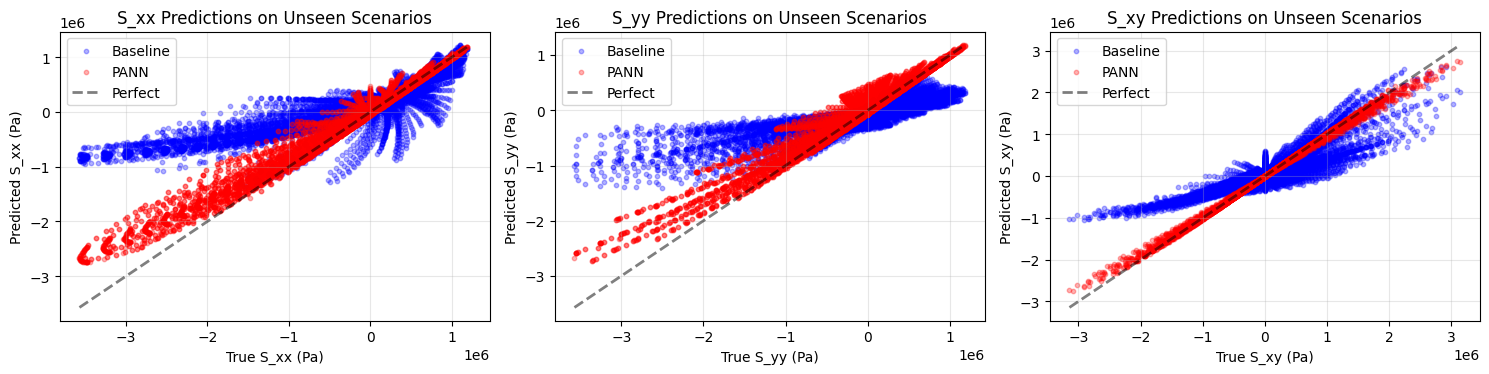

Closer to diagonal = better predictions


In [14]:
# Prediction scatter plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
component_names = ['S_xx', 'S_yy', 'S_xy']

for i, (ax, comp) in enumerate(zip(axes, component_names)):
    # Plot baseline
    ax.scatter(y_test_unseen[:, i], y_pred_baseline_unseen[:, i], 
               alpha=0.3, s=10, label='Baseline', c='blue')
    
    # Plot PANN
    ax.scatter(y_test_unseen[:, i], y_pred_pann_unseen[:, i], 
               alpha=0.3, s=10, label='PANN', c='red')
    
    # Perfect prediction line
    all_vals = np.concatenate([y_test_unseen[:, i], y_pred_baseline_unseen[:, i], y_pred_pann_unseen[:, i]])
    min_val, max_val = all_vals.min(), all_vals.max()
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, alpha=0.5, label='Perfect')
    
    ax.set_xlabel(f'True {comp} (Pa)')
    ax.set_ylabel(f'Predicted {comp} (Pa)')
    ax.set_title(f'{comp} Predictions on Unseen Scenarios')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Closer to diagonal = better predictions")

## Summary

This notebook provides a **parametric framework** for testing PANN's generalization capabilities:

### Configuration
- Easily modify `training_scenarios` and `test_only_scenarios` at the top
- Current setup: balanced training set excluding sphere and some complex cases

### Key Metrics
1. **Generalization Gap**: Performance drop from seen to unseen scenarios
2. **Absolute R² on Unseen**: Direct performance comparison
3. **Per-Scenario Breakdown**: Identify where each model excels

### Expected Results
PANN should demonstrate:
- Smaller generalization gap (more consistent)
- Better R² on unseen scenarios (especially sphere)
- Physics constraints enabling better extrapolation

### Experimentation
Try different configurations:
- More training scenarios → easier task
- Fewer training scenarios → harder generalization
- Different scenario combinations → test specific hypotheses